# 21cm Sensitivity Plots

## Load

In [255]:
%load_ext autoreload
import sys
sys.path.append("..")

#Current Working Directory
import os
cwd = os.getcwd()

from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

# np.set_printoptions(threshold=np.nan)

Load standard solution

In [257]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

Load photon transfer functions

In [258]:
user = '/Users/gridgway'
CMB_subtracted=True
direc = user+'/Dropbox (MIT)/Photon Deposition/tfs_20190120'
highengphot_tf_interp = pickle.load(open(direc+"/processed/highengphot_tf_interp.raw", "rb"))
lowengphot_tf_interp  = pickle.load(open(direc+"/processed/lowengphot_tf_interp.raw", "rb"))
lowengelec_tf_interp  = pickle.load(open(direc+"/processed/lowengelec_tf_interp.raw", "rb"))
highengdep_interp     = pickle.load(open(direc+"/processed/highengdep_interp.raw", "rb"))
CMB_engloss_interp    = pickle.load(open(direc+"/processed/CMB_engloss_interp.raw", "rb"))
    
# Useful Definitions
photeng = highengphot_tf_interp.eng
eleceng = lowengelec_tf_interp.eng

Load electron transfer functions

In [259]:
%autoreload
direc = cwd+'/../../tfs/ics/'
ics_file = Path(direc+'ics_thomson_ref_tf.p')

if ics_file.is_file():
    ics_thomson_ref_tf = pickle.load(open(direc+'ics_thomson_ref_tf.p', "rb"))
    ics_rel_ref_tf = pickle.load(open(direc+'ics_rel_ref_tf.p', "rb"))
    engloss_ref_tf = pickle.load(open(direc+'engloss_ref_tf.p', "rb"))
else:
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()
    pickle.dump(ics_thomson_ref_tf, open(direc+'ics_thomson_ref_tf.p', "wb"))
    pickle.dump(ics_rel_ref_tf, open(direc+'ics_rel_ref_tf.p', "wb"))
    pickle.dump(engloss_ref_tf, open(direc+'engloss_ref_tf.p', "wb"))

### Download xe_idl

In [260]:
direc = cwd+'/../../ih_continuous_'+inj_str

hdul = fits.open(
    direc+'/IDL_runs/'
    +'tf_z_3.000E+03_nstep_6398_logE_1.067E+01_xe_0.000E+00.fits'
)
    
data = hdul[1].data

idl_redshift = data.field('redshift')[0]
xe_idl = data.field('hionfraction')[0]
xHe_idl = data.field('heionfraction')[0]

hdul.close()

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))
xHe_idl_func = interp1d(idl_redshift, xHe_idl, bounds_error=False, fill_value=(xHe_idl[-1], xHe_idl[0]))

### Structure Formation

In [261]:
struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))

log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))

def struct_boost_einasto(rs):
    #if rs is actually a list of redshifts
    if hasattr(rs, "__len__"):
        rs_tmp = rs.copy()
        rs_tmp[rs>76] = 76
        tmp = np.exp(log_struct_interp(np.log(rs_tmp)))
        tmp[rs>76] = 1
        return tmp
    else:
        if rs < 76:
            return np.exp(log_struct_interp(np.log(rs)))
        else:
            return 1

## $T_{21}$ input

Calculate upper bound for $T_m$ using 
$$
    T_\text{21}(z) \approx (1-\frac{T_R}{T_S})
$$
where the constant of proportionality is given by 
$$
    \sqrt{\frac{.15}{10}} ...
$$
and we have assumed $T_R(z) = T_\text{CMB}(z)$ 

Calculate the $T_{IGM}$ bound provided a measurement of $T_{21}$

In [497]:
T_21 = -50 #in mK
tmp_xe = xe_std(end_rs)
num = np.sqrt(.15/10/phys.omega_m*end_rs)*(phys.omega_baryon*phys.h/.02)*(1-tmp_xe)*23
one_minus_ratio = T_21 / num
Tm_bnd = phys.TCMB(end_rs)/(1-one_minus_ratio)/phys.kB
print("T_m < ", Tm_bnd, "K")

T_m <  20.470087738353026 K


# Scan through $m_\chi$ and $\tau$ or $\sigma v$

## swave annihilation

Specify type of injection (swave or decay) and products ($e^+e^-$ or $\gamma\gamma$)

In [690]:
inj_particle = 'photon'
inj_str = inj_particle[:4]
inj_type = 'swave'

if inj_type == 'swave':
    struct_boost = struct_boost_einasto
    struct_func = struct_boost
else:
    def struct_boost(rs):
        return 1
    struct_func = None
    
if inj_particle == 'photon':
    mass = 0
    coarsen_factor=4
else:
    mass = phys.me
    coarsen_factor=12
    
end_rs = 18.2
rs_init = 3000

Given a dark matter mass and $\tau$ or $\sigma v$, calculate $T(z=17.2)$.

In [691]:
def get_T(mDM, log10_p, std_soln):
    if inj_type == 'decay':
        Einj = mDM/2-mass
        Ecom=mDM
    if inj_type == 'swave':
        Einj = mDM - mass
        Ecom = 2*mDM

    if inj_particle == 'photon':
        Etmp = photeng[photeng < Einj][-1]
        phot_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            photeng
        )
        phot_spec_init.rs = rs_init
        phot_spec_init.switch_spec_type()

        elec_spec_init = Spectrum(eleceng,
                                 np.zeros_like(eleceng),
                                 spec_type='N',
                                 rs=rs_init)
    else:
        Etmp = eleceng[eleceng < Einj][-1]
        elec_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            eleceng
        )
        elec_spec_init.rs = rs_init
        elec_spec_init.switch_spec_type()

        phot_spec_init = Spectrum(photeng,
                                 np.zeros_like(photeng),
                                 spec_type='N',
                                 rs=rs_init)

    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, tau=10**log10_p, sigmav=10**log10_p*mDM/1e9)*struct_boost(rs)/Ecom
    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, tau=10**log10_p, sigmav=10**log10_p*mDM/1e9)*struct_boost(rs)

    a = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_N, rate_func_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=coarsen_factor, std_soln=std_soln,
        reion_switch=False,
        struct_boost=struct_func,
        ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
        user=None, verbose=False, 
        use_tqdm=True
    )
    return a[1][-1]/phys.kB

Set up a $(m_\chi, \tau \text{ or } \sigma v)$ grid over which to scan

In [692]:
%autoreload
step = .25
if inj_particle == 'photon':
    mbnds = [4,12.5]
    log10mDM_arr = np.arange(mbnds[0], mbnds[1], step)

    if inj_type == 'decay':
        parambnds = [23,28.25 + step] #tau
        param_guess = 27
    else:
        parambnds = [-28,-25 + step] # sigma v / mDM
        param_guess = -27
else:
    mbnds = [6.01,12.51]
    log10mDM_arr = np.arange(mbnds[0], mbnds[1], step)

    if inj_type == 'decay':
        parambnds = [24,28.25 + step]
        param_guess = 27
    else:    
        parambnds = [-30.5,-24.5 + step]
        param_guess = -26
    
log10_param = np.arange(parambnds[0], parambnds[1], step)

Conduct the scan without back-reaction

In [695]:
%autoreload
T_IGM_17_std = np.zeros((log10mDM_arr.size, log10_param.size))

for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
    print('log10(mDM): ', log10mDM)
    mDM = 10**log10mDM
    j=len(log10_param[log10_param < param_guess])
    above=False
    below=False

    while((not below) or (not above)):
        log10_p = log10_param[j]
        print('log10(param): ', log10_p)

        T_std = get_T(mDM, log10_p, True)
        T_IGM_17_std[i,j] = T_std
        print('T_0 [K]: ', T_std)

        if T_std > Tm_bnd:
            above = True
            print("T_std Above Threshold")
            j = j-1
        else:
            below = True
            print("T_std Below Threshold")
            j = j+1
            
        param_guess = log10_p        
                    
pickle.dump(
    T_IGM_17_std, 
    open('/Users/gridgway/Desktop/T_IGM_17_'+
         inj_str+'_'+inj_type+'_std_coarsen'+str(coarsen_factor)+'.dat','wb')
)

log10(mDM):  4.0
log10(param):  -27.0


T_0 [K]:  11.127757380309532
T_std Below Threshold
log10(param):  -26.75


T_0 [K]:  13.262377017016656
T_std Below Threshold
log10(param):  -26.5


T_0 [K]:  16.487752460037555
T_std Below Threshold
log10(param):  -26.25


T_0 [K]:  21.535809676604266
T_std Above Threshold
log10(mDM):  4.25
log10(param):  -26.25


T_0 [K]:  18.801113650556587
T_std Below Threshold
log10(param):  -26.0


T_0 [K]:  24.982674031709905
T_std Above Threshold
log10(mDM):  4.5
log10(param):  -26.0


T_0 [K]:  24.55424775503311
T_std Above Threshold
log10(param):  -26.25


T_0 [K]:  18.4175602441396
T_std Below Threshold
log10(mDM):  4.75
log10(param):  -26.25


T_0 [K]:  18.435582266741257
T_std Below Threshold
log10(param):  -26.0


T_0 [K]:  24.742836748438656
T_std Above Threshold
log10(mDM):  5.0
log10(param):  -26.0


T_0 [K]:  25.57970434377983
T_std Above Threshold
log10(param):  -26.25


T_0 [K]:  18.844895548257245
T_std Below Threshold
log10(mDM):  5.25
log10(param):  -26.25


T_0 [K]:  18.966034038771546
T_std Below Threshold
log10(param):  -26.0


T_0 [K]:  25.936400927417825
T_std Above Threshold
log10(mDM):  5.5
log10(param):  -26.0


T_0 [K]:  24.024760392633063
T_std Above Threshold
log10(param):  -26.25


T_0 [K]:  17.725181452257267
T_std Below Threshold
log10(mDM):  5.75
log10(param):  -26.25


T_0 [K]:  15.480518420278482
T_std Below Threshold
log10(param):  -26.0


T_0 [K]:  20.395134644727964
T_std Below Threshold
log10(param):  -25.75


T_0 [K]:  28.442555656348173
T_std Above Threshold
log10(mDM):  6.0
log10(param):  -25.75


T_0 [K]:  21.086628733827514
T_std Above Threshold
log10(param):  -26.0


T_0 [K]:  15.954482133873043
T_std Below Threshold
log10(mDM):  6.25
log10(param):  -26.0


T_0 [K]:  13.059369574992186
T_std Below Threshold
log10(param):  -25.75


T_0 [K]:  16.311793468330006
T_std Below Threshold
log10(param):  -25.5


T_0 [K]:  21.47824304609859
T_std Above Threshold
log10(mDM):  6.5
log10(param):  -25.5


T_0 [K]:  16.180853109993862
T_std Below Threshold
log10(param):  -25.25


T_0 [K]:  20.745626366544318
T_std Above Threshold
log10(mDM):  6.75
log10(param):  -25.25


T_0 [K]:  17.061185287970524
T_std Below Threshold
log10(param):  -25.0


/Users/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


T_0 [K]:  21.423866358615435
T_std Above Threshold
log10(mDM):  7.0
log10(param):  -25.0


T_0 [K]:  20.795296417593274
T_std Above Threshold
log10(param):  -25.25


T_0 [K]:  16.96874182068424
T_std Below Threshold
log10(mDM):  7.25
log10(param):  -25.25


T_0 [K]:  23.58269801608868
T_std Above Threshold
log10(param):  -25.5


T_0 [K]:  18.435777155242622
T_std Below Threshold
log10(mDM):  7.5
log10(param):  -25.5


T_0 [K]:  22.626305368683436
T_std Above Threshold
log10(param):  -25.75


T_0 [K]:  17.65531426322797
T_std Below Threshold
log10(mDM):  7.75
log10(param):  -25.75


T_0 [K]:  19.299619139076434
T_std Below Threshold
log10(param):  -25.5


T_0 [K]:  25.398636550776974
T_std Above Threshold
log10(mDM):  8.0
log10(param):  -25.5


T_0 [K]:  26.694302179979104
T_std Above Threshold
log10(param):  -25.75


T_0 [K]:  20.11343811308151
T_std Below Threshold
log10(mDM):  8.25
log10(param):  -25.75


T_0 [K]:  20.621930314064866
T_std Above Threshold
log10(param):  -26.0


T_0 [K]:  16.36489465636492
T_std Below Threshold
log10(mDM):  8.5
log10(param):  -26.0


T_0 [K]:  16.291417888968077
T_std Below Threshold
log10(param):  -25.75


T_0 [K]:  20.482691020590863
T_std Above Threshold
log10(mDM):  8.75
log10(param):  -25.75


T_0 [K]:  19.533703621760697
T_std Below Threshold
log10(param):  -25.5


T_0 [K]:  25.544318438745357
T_std Above Threshold
log10(mDM):  9.0
log10(param):  -25.5


T_0 [K]:  23.347557313611155
T_std Above Threshold
log10(param):  -25.75


T_0 [K]:  18.146707183828788
T_std Below Threshold
log10(mDM):  9.25
log10(param):  -25.75


T_0 [K]:  16.31102167963639
T_std Below Threshold
log10(param):  -25.5


T_0 [K]:  20.474878728892037
T_std Above Threshold
log10(mDM):  9.5
log10(param):  -25.5


T_0 [K]:  18.10238037453066
T_std Below Threshold
log10(param):  -25.25


T_0 [K]:  23.164894972251897
T_std Above Threshold
log10(mDM):  9.75
log10(param):  -25.25


T_0 [K]:  19.73479542981055
T_std Below Threshold
log10(param):  -25.0


T_0 [K]:  25.493839034694563
T_std Above Threshold
log10(mDM):  10.0
log10(param):  -25.0


T_0 [K]:  22.404586473274716
T_std Above Threshold
log10(param):  -25.25


T_0 [K]:  17.954530463266916
T_std Below Threshold
log10(mDM):  10.25
log10(param):  -25.25


T_0 [K]:  17.389557456398503
T_std Below Threshold
log10(param):  -25.0


T_0 [K]:  21.293215419260875
T_std Above Threshold
log10(mDM):  10.5
log10(param):  -25.0


T_0 [K]:  21.20374826172236
T_std Above Threshold
log10(param):  -25.25


T_0 [K]:  17.374966877309763
T_std Below Threshold
log10(mDM):  10.75
log10(param):  -25.25


T_0 [K]:  17.092181218185456
T_std Below Threshold
log10(param):  -25.0


T_0 [K]:  20.81482449596477
T_std Above Threshold
log10(mDM):  11.0
log10(param):  -25.0


T_0 [K]:  21.64295327075206
T_std Above Threshold
log10(param):  -25.25


T_0 [K]:  17.581517494652907
T_std Below Threshold
log10(mDM):  11.25
log10(param):  -25.25


T_0 [K]:  18.404869686682073
T_std Below Threshold
log10(param):  -25.0


T_0 [K]:  22.890788119559414
T_std Above Threshold
log10(mDM):  11.5
log10(param):  -25.0


T_0 [K]:  23.14154323023001
T_std Above Threshold
log10(param):  -25.25


T_0 [K]:  18.6020196545681
T_std Below Threshold
log10(mDM):  11.75
log10(param):  -25.25


T_0 [K]:  18.46902259586664
T_std Below Threshold
log10(param):  -25.0


T_0 [K]:  22.942292276647155
T_std Above Threshold
log10(mDM):  12.0
log10(param):  -25.0


T_0 [K]:  22.79002740926359
T_std Above Threshold
log10(param):  -25.25


T_0 [K]:  18.359477512260682
T_std Below Threshold
log10(mDM):  12.25
log10(param):  -25.25


T_0 [K]:  18.614713192456595
T_std Below Threshold
log10(param):  -25.0


T_0 [K]:  23.24096061303542
T_std Above Threshold



In [696]:
def find_param(Tlist):
    above = np.nonzero(Tlist > T_m)[0][0]
    below = np.nonzero(Tlist[:above] < T_m)[0][-1]
    Ts = [Tlist[below], Tlist[above]]
    ps = [log10_param[below], log10_param[above]]
    return (np.diff(ps)/np.diff(Ts)*(T_m-Ts[0]) + ps[0])[0]

thresh_params_std = np.array([find_param(row) for row in T_IGM_17_std])

Conduct the scan with back-reaction

In [697]:
%autoreload
T_IGM_17_BR = np.zeros((log10mDM_arr.size, log10_param.size))
param_guess = thresh_params_std[0]

for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
    print('log10(mDM): ', log10mDM)
    mDM = 10**log10mDM
    j=len(log10_param[log10_param < param_guess])
    above=False
    below=False

    while((not below) or (not above)):
        log10_p = log10_param[j]
        print('log10(param): ', log10_p)

        T_BR = get_T(mDM, log10_p, False)
        T_IGM_17_BR[i,j] = T_BR
        print('T_0 [K]: ', T_BR)

        if T_BR > Tm_bnd:
            above = True
            print("T_BR Above Threshold")
            j = j-1
        else:
            below = True
            print("T_BR Below Threshold")
            j = j+1
        param_guess = log10_p
        
                    
pickle.dump(
    T_IGM_17_BR, 
    open('/Users/gridgway/Desktop/T_IGM_17_'+
         inj_str+'_'+inj_type+'_BR_coarsen'+str(coarsen_factor)+'.dat','wb')
)

log10(mDM):  4.0
log10(param):  -26.25


T_0 [K]:  24.662944508117597
T_BR Above Threshold
log10(param):  -26.5


T_0 [K]:  17.883355062372658
T_BR Below Threshold
log10(mDM):  4.25
log10(param):  -26.5


T_0 [K]:  15.714742741613685
T_BR Below Threshold
log10(param):  -26.25


T_0 [K]:  20.71294074727853
T_BR Above Threshold
log10(mDM):  4.5
log10(param):  -26.25


T_0 [K]:  20.100302328750907
T_BR Below Threshold
log10(param):  -26.0


T_0 [K]:  28.2985550450351
T_BR Above Threshold
log10(mDM):  4.75
log10(param):  -26.0


T_0 [K]:  29.14002409784055
T_BR Above Threshold
log10(param):  -26.25


T_0 [K]:  20.41564196173362
T_BR Below Threshold
log10(mDM):  5.0
log10(param):  -26.25


T_0 [K]:  21.50450473414991
T_BR Above Threshold
log10(param):  -26.5


T_0 [K]:  15.859801934712328
T_BR Below Threshold
log10(mDM):  5.25
log10(param):  -26.5


T_0 [K]:  16.0009742417345
T_BR Below Threshold
log10(param):  -26.25


T_0 [K]:  21.988833670834367
T_BR Above Threshold
log10(mDM):  5.5
log10(param):  -26.25


T_0 [K]:  20.35087313395289
T_BR Below Threshold
log10(param):  -26.0


T_0 [K]:  29.916998703070504
T_BR Above Threshold
log10(mDM):  5.75
log10(param):  -26.0


T_0 [K]:  24.38453826009741
T_BR Above Threshold
log10(param):  -26.25


T_0 [K]:  17.21933418859081
T_BR Below Threshold
log10(mDM):  6.0
log10(param):  -26.25


T_0 [K]:  13.536523728120153
T_BR Below Threshold
log10(param):  -26.0


T_0 [K]:  17.901937793608997
T_BR Below Threshold
log10(param):  -25.75


T_0 [K]:  25.507247163854935
T_BR Above Threshold
log10(mDM):  6.25
log10(param):  -25.75


T_0 [K]:  18.404517864134625
T_BR Below Threshold
log10(param):  -25.5


T_0 [K]:  26.153317543717204
T_BR Above Threshold
log10(mDM):  6.5
log10(param):  -25.5


T_0 [K]:  18.152760865067528
T_BR Below Threshold
log10(param):  -25.25


T_0 [K]:  25.003563453183254
T_BR Above Threshold
log10(mDM):  6.75
log10(param):  -25.25


T_0 [K]:  19.298772837058603
T_BR Below Threshold
log10(param):  -25.0


/Users/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


T_0 [K]:  26.046931097749148
T_BR Above Threshold
log10(mDM):  7.0
log10(param):  -25.0


T_0 [K]:  25.719263982414013
T_BR Above Threshold
log10(param):  -25.25


T_0 [K]:  19.440774739753795
T_BR Below Threshold
log10(mDM):  7.25
log10(param):  -25.25


T_0 [K]:  31.089661543325096
T_BR Above Threshold
log10(param):  -25.5


T_0 [K]:  22.142325401346362
T_BR Above Threshold
log10(param):  -25.75


T_0 [K]:  16.991146131087913
T_BR Below Threshold
log10(mDM):  7.5
log10(param):  -25.75


T_0 [K]:  20.478090506582202
T_BR Above Threshold
log10(param):  -26.0


T_0 [K]:  15.850718371684794
T_BR Below Threshold
log10(mDM):  7.75
log10(param):  -26.0


T_0 [K]:  16.972987777442253
T_BR Below Threshold
log10(param):  -25.75


T_0 [K]:  22.452258054916186
T_BR Above Threshold
log10(mDM):  8.0
log10(param):  -25.75


T_0 [K]:  23.2192457670853
T_BR Above Threshold
log10(param):  -26.0


T_0 [K]:  17.464252242521404
T_BR Below Threshold
log10(mDM):  8.25
log10(param):  -26.0


T_0 [K]:  17.76155872734942
T_BR Below Threshold
log10(param):  -25.75


T_0 [K]:  23.60450448364913
T_BR Above Threshold
log10(mDM):  8.5
log10(param):  -25.75


T_0 [K]:  23.244411130117097
T_BR Above Threshold
log10(param):  -26.0


T_0 [K]:  17.58250374481945
T_BR Below Threshold
log10(mDM):  8.75
log10(param):  -26.0


T_0 [K]:  16.74557402142903
T_BR Below Threshold
log10(param):  -25.75


T_0 [K]:  21.842522548940124
T_BR Above Threshold
log10(mDM):  9.0
log10(param):  -25.75


T_0 [K]:  19.939744964606234
T_BR Below Threshold
log10(param):  -25.5


T_0 [K]:  27.135243101422876
T_BR Above Threshold
log10(mDM):  9.25
log10(param):  -25.5


T_0 [K]:  23.08779037621177
T_BR Above Threshold
log10(param):  -25.75


T_0 [K]:  17.531941889422708
T_BR Below Threshold
log10(mDM):  9.5
log10(param):  -25.75


T_0 [K]:  15.627459782993093
T_BR Below Threshold
log10(param):  -25.5


T_0 [K]:  19.890425543838145
T_BR Below Threshold
log10(param):  -25.25


T_0 [K]:  26.92060998039796
T_BR Above Threshold
log10(mDM):  9.75
log10(param):  -25.25


T_0 [K]:  22.160625871298688
T_BR Above Threshold
log10(param):  -25.5


T_0 [K]:  17.172982718430188
T_BR Below Threshold
log10(mDM):  10.0
log10(param):  -25.5


T_0 [K]:  15.888007256729647
T_BR Below Threshold
log10(param):  -25.25


T_0 [K]:  19.762489421683913
T_BR Below Threshold
log10(param):  -25.0


T_0 [K]:  26.08434481237296
T_BR Above Threshold
log10(mDM):  10.25
log10(param):  -25.0


T_0 [K]:  24.543701298716346
T_BR Above Threshold
log10(param):  -25.25


T_0 [K]:  19.005261150111867
T_BR Below Threshold
log10(mDM):  10.5
log10(param):  -25.25


T_0 [K]:  18.97473968891912
T_BR Below Threshold
log10(param):  -25.0


T_0 [K]:  24.418246942233633
T_BR Above Threshold
log10(mDM):  10.75
log10(param):  -25.0


T_0 [K]:  23.819180852575435
T_BR Above Threshold
log10(param):  -25.25


T_0 [K]:  18.578123470076438
T_BR Below Threshold
log10(mDM):  11.0
log10(param):  -25.25


T_0 [K]:  19.19130639189246
T_BR Below Threshold
log10(param):  -25.0


T_0 [K]:  24.917342906142757
T_BR Above Threshold
log10(mDM):  11.25
log10(param):  -25.0


T_0 [K]:  26.737950585173166
T_BR Above Threshold
log10(param):  -25.25


T_0 [K]:  20.30107339755952
T_BR Below Threshold
log10(mDM):  11.5
log10(param):  -25.25


T_0 [K]:  20.59596503194243
T_BR Above Threshold
log10(param):  -25.5


T_0 [K]:  16.52498206083622
T_BR Below Threshold
log10(mDM):  11.75
log10(param):  -25.5


T_0 [K]:  16.406805392927357
T_BR Below Threshold
log10(param):  -25.25


T_0 [K]:  20.423680358064402
T_BR Below Threshold
log10(param):  -25.0


T_0 [K]:  26.895014185233403
T_BR Above Threshold
log10(mDM):  12.0
log10(param):  -25.0


T_0 [K]:  26.661561210143308
T_BR Above Threshold
log10(param):  -25.25


T_0 [K]:  20.271624834890606
T_BR Below Threshold
log10(mDM):  12.25
log10(param):  -25.25


T_0 [K]:  20.633720051225218
T_BR Above Threshold
log10(param):  -25.5


T_0 [K]:  16.500943324947283
T_BR Below Threshold



### Plots

In [445]:
# inj_particle = 'electron'
# inj_str = inj_particle[:4]
# inj_type = 'swave'
# coarsen_factor=12
# T_IGM_17_std = pickle.load(
#     open('/Users/gridgway/Desktop/T_IGM_17_elec_swave_std_coarsen12.dat','rb')
# )

In [698]:
thresh_params_BR = np.array([find_param(row) for row in T_IGM_17_BR])

std_interp = interp1d(log10mDM_arr, thresh_params_std, kind='quadratic')
BR_interp = interp1d(log10mDM_arr, thresh_params_BR, kind='quadratic')

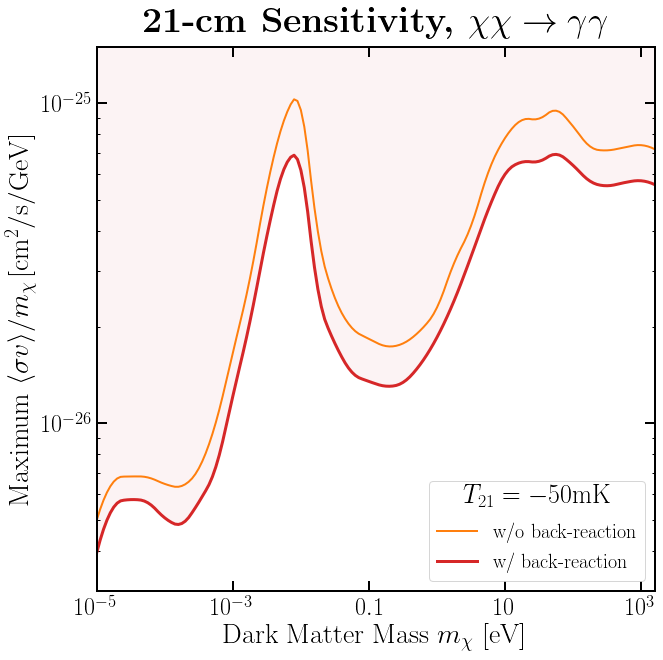

In [703]:
plt.figure()
ax = plt.gca()
ax.loglog()

xmin = 10**log10mDM_arr_fine[0]/1e9
xmax = 10**log10mDM_arr_fine[-1]/1e9

if inj_particle=='electron':
    plt.title(r'\bf{21-cm Sensitivity,} $\chi \chi \to e^+ e^-$')
    ymin = 5e-29
    ymax = 1e-25
else:
    plt.title(r'\bf{21-cm Sensitivity,} $\chi\chi \to \gamma\gamma$')
    ymin = 3e-27
    ymax = 1.5e-25
    
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
plt.ylabel(r'Maximum $\langle \sigma v \rangle / m_\chi \, [\mathrm{ cm^2 / s / GeV}]$')
plt.axis([xmin, xmax, ymin, ymax])

plt_std, = plt.plot(10**log10mDM_arr_fine/1e9, 10**std_interp(log10mDM_arr_fine), 
        linewidth=2, label='w/o back-reaction', color='C1')
plt_BR, = plt.plot(10**log10mDM_arr_fine/1e9, 10**BR_interp(log10mDM_arr_fine), 
         linewidth=3, label='w/ back-reaction', color='C3')

ax.fill_between(
    10**log10mDM_arr_fine/1e9, 
    1e-15, 
    (10**BR_interp(log10mDM_arr_fine)), 
    interpolate=True, 
    color='C3',
    alpha=.05
)

leg = plt.legend(handles=[plt_std, plt_BR],
                 fontsize=20,
          title='$T_{21} = -50$mK')
plt.setp(leg.get_title(), fontsize=26)

plt.savefig('/Users/gridgway/Dropbox (MIT)/Photon Deposition/Draft/plots/'+
            'DarkHistory_21cm_Sensitivity_'+inj_type+'_'+inj_str+'.png')

# Decay

In [673]:
inj_particle = 'photon'
inj_str = inj_particle[:4]
inj_type = 'decay'

if inj_type == 'swave':
    struct_boost = struct_boost_einasto
    struct_func = struct_boost
else:
    def struct_boost(rs):
        return 1
    struct_func = None
    
if inj_particle == 'photon':
    mass = 0
    coarsen_factor=4
else:
    mass = phys.me
    coarsen_factor=12
    
end_rs = 18.2
rs_init = 3000

In [674]:
def get_T(mDM, log10_p, std_soln):
    if inj_type == 'decay':
        Einj = mDM/2-mass
        Ecom=mDM
    if inj_type == 'swave':
        Einj = mDM - mass
        Ecom = 2*mDM

    if inj_particle == 'photon':
        Etmp = photeng[photeng < Einj][-1]
        phot_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            photeng
        )
        phot_spec_init.rs = rs_init
        phot_spec_init.switch_spec_type()

        elec_spec_init = Spectrum(eleceng,
                                 np.zeros_like(eleceng),
                                 spec_type='N',
                                 rs=rs_init)
    else:
        Etmp = eleceng[eleceng < Einj][-1]
        elec_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            eleceng
        )
        elec_spec_init.rs = rs_init
        elec_spec_init.switch_spec_type()

        phot_spec_init = Spectrum(photeng,
                                 np.zeros_like(photeng),
                                 spec_type='N',
                                 rs=rs_init)

    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, tau=10**log10_p, sigmav=10**log10_p*mDM/1e9)*struct_boost(rs)/Ecom
    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, tau=10**log10_p, sigmav=10**log10_p*mDM/1e9)*struct_boost(rs)

    a = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_N, rate_func_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=coarsen_factor, std_soln=std_soln,
        reion_switch=False,
        struct_boost=struct_func,
        ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
        user=None, verbose=False, 
        use_tqdm=True
    )
    return a[1][-1]/phys.kB

In [709]:
%autoreload
step = .25
if inj_particle == 'photon':
    mbnds = [4,12.5]
    log10mDM_arr = np.arange(mbnds[0], mbnds[1], step)

    if inj_type == 'decay':
        parambnds = [23,28.25 + step] #tau
        param_guess = 27
    else:
        parambnds = [-28,-25 + step] # sigma v / mDM
        param_guess = -27
else:
    mbnds = [6.01,12.51]
    log10mDM_arr = np.arange(mbnds[0], mbnds[1], step)

    if inj_type == 'decay':
        parambnds = [24,28.25 + step]
        param_guess = 27
    else:    
        parambnds = [-30.5,-24.5 + step]
        param_guess = -26
    
log10_param = np.arange(parambnds[0], parambnds[1], step)

In [676]:
T_21 = -50 #in mK
tmp_xe = xe_std(end_rs)
num = np.sqrt(.15/10/phys.omega_m*end_rs)*(phys.omega_baryon*phys.h/.02)*(1-tmp_xe)*23
one_minus_ratio = T_21 / num
Tm_bnd = phys.TCMB(end_rs)/(1-one_minus_ratio)/phys.kB
print("T_m < ", Tm_bnd, "K")

T_m <  20.470087738353026 K


In [677]:
%autoreload
T_IGM_17_std = np.zeros((log10mDM_arr.size, log10_param.size))
BR_guesses = np.zeros(log10mDM_arr.size)

for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
    print('log10(mDM): ', log10mDM)
    mDM = 10**log10mDM
    j=len(log10_param[log10_param < param_guess])
    above=False
    below=False

    while((not below) or (not above)):
        log10_p = log10_param[j]
        print('log10(param): ', log10_p)

        T_std = get_T(mDM, log10_p, True)
        T_IGM_17_std[i,j] = T_std
        print('T_0 [K]: ', T_std)

        if T_std > Tm_bnd:
            above = True
            print("T_std Above Threshold")
            j = j+1
        else:
            below = True
            print("T_std Below Threshold")
            j = j-1
            
        param_guess = log10_p
        BR_guesses[i] = log10_param[j-1]
        
                    
pickle.dump(
    T_IGM_17_std, 
#     open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_std_NFW_no_subs_source.dat','wb')
    open('/Users/gridgway/Desktop/T_IGM_17_'+
         inj_str+'_'+inj_type+'_std_coarsen'+str(coarsen_factor)+'.dat','wb')
)

log10(mDM):  4.0
log10(param):  27.0


T_0 [K]:  10.605130663955412
T_std Below Threshold
log10(param):  26.75


T_0 [K]:  13.32413287312343
T_std Below Threshold
log10(param):  26.5


T_0 [K]:  18.090003094790653
T_std Below Threshold
log10(param):  26.25


T_0 [K]:  26.361752018681965
T_std Above Threshold
log10(mDM):  4.25
log10(param):  26.25


T_0 [K]:  14.12077463402651
T_std Below Threshold
log10(param):  26.0


T_0 [K]:  19.426565526437482
T_std Below Threshold
log10(param):  25.75


T_0 [K]:  28.542599603898562
T_std Above Threshold
log10(mDM):  4.5
log10(param):  25.75


T_0 [K]:  14.952230448498515
T_std Below Threshold
log10(param):  25.5


T_0 [K]:  20.75209119432511
T_std Above Threshold
log10(mDM):  4.75
log10(param):  25.5


T_0 [K]:  16.425064555076748
T_std Below Threshold
log10(param):  25.25


T_0 [K]:  23.114305113871175
T_std Above Threshold
log10(mDM):  5.0
log10(param):  25.25


T_0 [K]:  24.371343458424565
T_std Above Threshold
log10(param):  25.5


T_0 [K]:  17.235450913602705
T_std Below Threshold
log10(mDM):  5.25
log10(param):  25.5


T_0 [K]:  19.241204570810783
T_std Below Threshold
log10(param):  25.25


T_0 [K]:  27.684526223155647
T_std Above Threshold
log10(mDM):  5.5
log10(param):  25.25


T_0 [K]:  30.668077998119614
T_std Above Threshold
log10(param):  25.5


T_0 [K]:  20.974826653801028
T_std Above Threshold
log10(param):  25.75


T_0 [K]:  15.154035069430853
T_std Below Threshold
log10(mDM):  5.75
log10(param):  25.75


T_0 [K]:  14.847699584695073
T_std Below Threshold
log10(param):  25.5


T_0 [K]:  20.52703882410808
T_std Above Threshold
log10(mDM):  6.0
log10(param):  25.5


T_0 [K]:  17.550856498628637
T_std Below Threshold
log10(param):  25.25


T_0 [K]:  25.179789477251614
T_std Above Threshold
log10(mDM):  6.25
log10(param):  25.25


T_0 [K]:  19.412863318860115
T_std Below Threshold
log10(param):  25.0


T_0 [K]:  28.381316656260662
T_std Above Threshold
log10(mDM):  6.5
log10(param):  25.0


T_0 [K]:  19.002392184345123
T_std Below Threshold
log10(param):  24.75


T_0 [K]:  27.690291398870404
T_std Above Threshold
log10(mDM):  6.75
log10(param):  24.75


T_0 [K]:  18.893413356321542
T_std Below Threshold
log10(param):  24.5


T_0 [K]:  27.205853493972903
T_std Above Threshold
log10(mDM):  7.0
log10(param):  24.5


T_0 [K]:  19.679456251117845
T_std Below Threshold
log10(param):  24.25


T_0 [K]:  27.24195436329243
T_std Above Threshold
log10(mDM):  7.25
log10(param):  24.25


T_0 [K]:  24.491041745274465
T_std Above Threshold
log10(param):  24.5


T_0 [K]:  18.88350194409202
T_std Below Threshold
log10(mDM):  7.5
log10(param):  24.5


T_0 [K]:  26.264713667616608
T_std Above Threshold
log10(param):  24.75


T_0 [K]:  19.634314547134064
T_std Below Threshold
log10(mDM):  7.75
log10(param):  24.75


T_0 [K]:  26.784790679774872
T_std Above Threshold
log10(param):  25.0


T_0 [K]:  19.31777694366554
T_std Below Threshold
log10(mDM):  8.0
log10(param):  25.0


T_0 [K]:  21.541408333983693
T_std Above Threshold
log10(param):  25.25


T_0 [K]:  15.766867956702601
T_std Below Threshold
log10(mDM):  8.25
log10(param):  25.25


T_0 [K]:  16.22409774526646
T_std Below Threshold
log10(param):  25.0


T_0 [K]:  22.489592069680167
T_std Above Threshold
log10(mDM):  8.5
log10(param):  25.0


T_0 [K]:  22.14404287697256
T_std Above Threshold
log10(param):  25.25


T_0 [K]:  15.933758828632051
T_std Below Threshold
log10(mDM):  8.75
log10(param):  25.25


T_0 [K]:  14.660402278988583
T_std Below Threshold
log10(param):  25.0


T_0 [K]:  20.104991079423332
T_std Below Threshold
log10(param):  24.75


T_0 [K]:  29.165288962668708
T_std Above Threshold
log10(mDM):  9.0
log10(param):  24.75


T_0 [K]:  24.71361490326093
T_std Above Threshold
log10(param):  25.0


T_0 [K]:  17.404086047509715
T_std Below Threshold
log10(mDM):  9.25
log10(param):  25.0


T_0 [K]:  14.333371364594939
T_std Below Threshold
log10(param):  24.75


T_0 [K]:  19.550627519227195
T_std Below Threshold
log10(param):  24.5


T_0 [K]:  28.247031250840788
T_std Above Threshold
log10(mDM):  9.5
log10(param):  24.5


T_0 [K]:  22.113896344019878
T_std Above Threshold
log10(param):  24.75


T_0 [K]:  15.895915054177003
T_std Below Threshold
log10(mDM):  9.75
log10(param):  24.75


T_0 [K]:  12.879607017577651
T_std Below Threshold
log10(param):  24.5


T_0 [K]:  17.001963803832655
T_std Below Threshold
log10(param):  24.25


T_0 [K]:  23.82228530712723
T_std Above Threshold
log10(mDM):  10.0
log10(param):  24.25


T_0 [K]:  18.72061852315338
T_std Below Threshold
log10(param):  24.0


T_0 [K]:  26.40480251494293
T_std Above Threshold
log10(mDM):  10.25
log10(param):  24.0


T_0 [K]:  20.6501231871981
T_std Above Threshold
log10(param):  24.25


T_0 [K]:  15.363184135829687
T_std Below Threshold
log10(mDM):  10.5
log10(param):  24.25


T_0 [K]:  13.043631213655274
T_std Below Threshold
log10(param):  24.0


T_0 [K]:  16.65890925498291
T_std Below Threshold
log10(param):  23.75


T_0 [K]:  22.306504591831775
T_std Above Threshold
log10(mDM):  10.75
log10(param):  23.75


T_0 [K]:  18.928818138165695
T_std Below Threshold
log10(param):  23.5


T_0 [K]:  25.55269292960686
T_std Above Threshold
log10(mDM):  11.0
log10(param):  23.5


T_0 [K]:  21.82317614319897
T_std Above Threshold
log10(param):  23.75


T_0 [K]:  16.642920345513573
T_std Below Threshold
log10(mDM):  11.25
log10(param):  23.75


T_0 [K]:  15.295050339053123
T_std Below Threshold
log10(param):  23.5


T_0 [K]:  19.658282292797978
T_std Below Threshold
log10(param):  23.25


T_0 [K]:  26.37706654075127
T_std Above Threshold
log10(mDM):  11.5
log10(param):  23.25


T_0 [K]:  24.452581549370745
T_std Above Threshold
log10(param):  23.5


T_0 [K]:  18.678725880245572
T_std Below Threshold
log10(mDM):  11.75
log10(param):  23.5


T_0 [K]:  19.8377988969872
T_std Below Threshold
log10(param):  23.25


T_0 [K]:  25.755699841809
T_std Above Threshold
log10(mDM):  12.0
log10(param):  23.25


T_0 [K]:  31.79598683698715
T_std Above Threshold
log10(param):  23.5


T_0 [K]:  23.89423761718133
T_std Above Threshold
log10(param):  23.75


T_0 [K]:  18.62879446471598
T_std Below Threshold
log10(mDM):  12.25
log10(param):  23.75


T_0 [K]:  22.23081975293835
T_std Above Threshold
log10(param):  24.0


T_0 [K]:  17.058350486145514
T_std Below Threshold



In [710]:
def find_param(Tlist):
    if inj_type == 'swave':
        above = np.nonzero(Tlist > T_m)[0][0]
        below = above-1
    else:
        above = np.nonzero(Tlist > T_m)[0][-1]
        below = above+1
    Ts = [Tlist[below], Tlist[above]]
    ps = [log10_param[below], log10_param[above]]
    return (np.diff(ps)/np.diff(Ts)*(T_m-Ts[0]) + ps[0])[0]

thresh_params_std = np.array([find_param(row) for row in T_IGM_17_std])

In [679]:
%autoreload
T_IGM_17_BR = np.zeros((log10mDM_arr.size, log10_param.size))
param_guess = thresh_params_std[0]

for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
    print('log10(mDM): ', log10mDM)
    mDM = 10**log10mDM
    j=len(log10_param[log10_param < param_guess])
    above=False
    below=False

    while((not below) or (not above)):
        log10_p = log10_param[j]
        print('log10(param): ', log10_p)

        T_BR = get_T(mDM, log10_p, False)
        T_IGM_17_BR[i,j] = T_BR
        print('T_0 [K]: ', T_BR)

        if T_BR > Tm_bnd:
            above = True
            print("T_BR Above Threshold")
            j = j+1
        else:
            below = True
            print("T_BR Below Threshold")
            j = j-1
        param_guess = log10_p
        
                    
pickle.dump(
    T_IGM_17_BR, 
    open('/Users/gridgway/Desktop/T_IGM_17_'+
         inj_str+'_'+inj_type+'_BR_coarsen'+str(coarsen_factor)+'.dat','wb')
)

log10(mDM):  4.0
log10(param):  26.5


T_0 [K]:  19.7694697035461
T_BR Below Threshold
log10(param):  26.25


T_0 [K]:  30.691710580008458
T_BR Above Threshold
log10(mDM):  4.25
log10(param):  26.25


T_0 [K]:  14.968529119338651
T_BR Below Threshold
log10(param):  26.0


T_0 [K]:  21.70945944473646
T_BR Above Threshold
log10(mDM):  4.5
log10(param):  26.0


T_0 [K]:  11.93798955915617
T_BR Below Threshold
log10(param):  25.75


T_0 [K]:  15.977567093674272
T_BR Below Threshold
log10(param):  25.5


T_0 [K]:  23.493532204346444
T_BR Above Threshold
log10(mDM):  4.75
log10(param):  25.5


T_0 [K]:  17.707757131388565
T_BR Below Threshold
log10(param):  25.25


T_0 [K]:  26.41913469754997
T_BR Above Threshold
log10(mDM):  5.0
log10(param):  25.25


T_0 [K]:  28.644695666336837
T_BR Above Threshold
log10(param):  25.5


T_0 [K]:  18.969533467983315
T_BR Below Threshold
log10(mDM):  5.25
log10(param):  25.5


T_0 [K]:  22.299708125510275
T_BR Above Threshold
log10(param):  25.75


T_0 [K]:  15.363040304837906
T_BR Below Threshold
log10(mDM):  5.5
log10(param):  25.75


T_0 [K]:  16.957760805452068
T_BR Below Threshold
log10(param):  25.5


T_0 [K]:  25.44551265528261
T_BR Above Threshold
log10(mDM):  5.75
log10(param):  25.5


T_0 [K]:  25.023645020563492
T_BR Above Threshold
log10(param):  25.75


T_0 [K]:  16.641165343101996
T_BR Below Threshold
log10(mDM):  6.0
log10(param):  25.75


T_0 [K]:  14.245296184484959
T_BR Below Threshold
log10(param):  25.5


T_0 [K]:  20.61481701055453
T_BR Above Threshold
log10(mDM):  6.25
log10(param):  25.5


T_0 [K]:  15.726256519188233
T_BR Below Threshold
log10(param):  25.25


T_0 [K]:  23.468444696659304
T_BR Above Threshold
log10(mDM):  6.5
log10(param):  25.25


T_0 [K]:  15.400185049565668
T_BR Below Threshold
log10(param):  25.0


T_0 [K]:  22.858309261632982
T_BR Above Threshold
log10(mDM):  6.75
log10(param):  25.0


T_0 [K]:  15.405753315722471
T_BR Below Threshold
log10(param):  24.75


T_0 [K]:  22.64095197840003
T_BR Above Threshold
log10(mDM):  7.0
log10(param):  24.75


T_0 [K]:  16.685614515688428
T_BR Below Threshold
log10(param):  24.5


T_0 [K]:  23.75424699645507
T_BR Above Threshold
log10(mDM):  7.25
log10(param):  24.5


T_0 [K]:  22.886482500714553
T_BR Above Threshold
log10(param):  24.75


T_0 [K]:  16.939578184287807
T_BR Below Threshold
log10(mDM):  7.5
log10(param):  24.75


T_0 [K]:  24.66924087519088
T_BR Above Threshold
log10(param):  25.0


T_0 [K]:  17.50455103465345
T_BR Below Threshold
log10(mDM):  7.75
log10(param):  25.0


T_0 [K]:  23.697963263942754
T_BR Above Threshold
log10(param):  25.25


T_0 [K]:  16.43980015877576
T_BR Below Threshold
log10(mDM):  8.0
log10(param):  25.25


T_0 [K]:  17.871444507708045
T_BR Below Threshold
log10(param):  25.0


T_0 [K]:  26.529939553728507
T_BR Above Threshold
log10(mDM):  8.25
log10(param):  25.0


T_0 [K]:  27.13907875497047
T_BR Above Threshold
log10(param):  25.25


T_0 [K]:  18.126387840760426
T_BR Below Threshold
log10(mDM):  8.5
log10(param):  25.25


T_0 [K]:  17.490726522332615
T_BR Below Threshold
log10(param):  25.0


T_0 [K]:  26.086821690996814
T_BR Above Threshold
log10(mDM):  8.75
log10(param):  25.0


T_0 [K]:  22.895334866286092
T_BR Above Threshold
log10(param):  25.25


T_0 [K]:  15.708698177128408
T_BR Below Threshold
log10(mDM):  9.0
log10(param):  25.25


T_0 [K]:  13.677536760620722
T_BR Below Threshold
log10(param):  25.0


T_0 [K]:  19.163727454228077
T_BR Below Threshold
log10(param):  24.75


T_0 [K]:  29.15346420356472
T_BR Above Threshold
log10(mDM):  9.25
log10(param):  24.75


T_0 [K]:  21.952987588328803
T_BR Above Threshold
log10(param):  25.0


T_0 [K]:  15.223671451726908
T_BR Below Threshold
log10(mDM):  9.5
log10(param):  25.0


T_0 [K]:  12.640379761162595
T_BR Below Threshold
log10(param):  24.75


T_0 [K]:  17.185595694447304
T_BR Below Threshold
log10(param):  24.5


T_0 [K]:  25.438769045687604
T_BR Above Threshold
log10(mDM):  9.75
log10(param):  24.5


T_0 [K]:  18.639761386765024
T_BR Below Threshold
log10(param):  24.25


T_0 [K]:  27.889045581996797
T_BR Above Threshold
log10(mDM):  10.0
log10(param):  24.25


T_0 [K]:  20.954926384037137
T_BR Above Threshold
log10(param):  24.5


T_0 [K]:  14.867930748366968
T_BR Below Threshold
log10(mDM):  10.25
log10(param):  24.5


T_0 [K]:  12.525347023189946
T_BR Below Threshold
log10(param):  24.25


T_0 [K]:  16.59917778715135
T_BR Below Threshold
log10(param):  24.0


T_0 [K]:  23.661100824685235
T_BR Above Threshold
log10(mDM):  10.5
log10(param):  24.0


T_0 [K]:  18.328360320667333
T_BR Below Threshold
log10(param):  23.75


T_0 [K]:  26.13983405470636
T_BR Above Threshold
log10(mDM):  10.75
log10(param):  23.75


T_0 [K]:  21.47202611028644
T_BR Above Threshold
log10(param):  24.0


T_0 [K]:  15.749990701776879
T_BR Below Threshold
log10(mDM):  11.0
log10(param):  24.0


T_0 [K]:  13.956417258087521
T_BR Below Threshold
log10(param):  23.75


T_0 [K]:  18.371534163819376
T_BR Below Threshold
log10(param):  23.5


T_0 [K]:  25.65475343519746
T_BR Above Threshold
log10(mDM):  11.25
log10(param):  23.5


T_0 [K]:  22.50795229222389
T_BR Above Threshold
log10(param):  23.75


T_0 [K]:  16.561847165333862
T_BR Below Threshold
log10(mDM):  11.5
log10(param):  23.75


T_0 [K]:  15.971336809238071
T_BR Below Threshold
log10(param):  23.5


T_0 [K]:  21.006814475240297
T_BR Above Threshold
log10(mDM):  11.75
log10(param):  23.5


T_0 [K]:  22.519451423942666
T_BR Above Threshold
log10(param):  23.75


T_0 [K]:  17.19748270442012
T_BR Below Threshold
log10(mDM):  12.0
log10(param):  23.75


T_0 [K]:  20.8561647724417
T_BR Above Threshold
log10(param):  24.0


T_0 [K]:  16.01820633939809
T_BR Below Threshold
log10(mDM):  12.25
log10(param):  24.0


T_0 [K]:  18.849434920517513
T_BR Below Threshold
log10(param):  23.75


T_0 [K]:  26.116165103907896
T_BR Above Threshold



### Plots

In [704]:
inj_type = 'decay'
inj_particle = 'photon'
inj_str = inj_particle[:4]

T_IGM_17_std = pickle.load(
    open('/Users/gridgway/Desktop/T_IGM_17_'+
         inj_str+'_'+inj_type+'_std_coarsen'+str(coarsen_factor)+'.dat','rb')
)
T_IGM_17_BR = pickle.load(
    open('/Users/gridgway/Desktop/T_IGM_17_'+
         inj_str+'_'+inj_type+'_BR_coarsen'+str(coarsen_factor)+'.dat','rb')
)

In [662]:
# inj_particle = 'electron'
# inj_str = inj_particle[:4]
# inj_type = 'swave'
# coarsen_factor=12
# T_IGM_17_std = pickle.load(
#     open('/Users/gridgway/Desktop/T_IGM_17_elec_swave_std_coarsen12.dat','rb')
# )

In [711]:
thresh_params_std = np.array([find_param(row) for row in T_IGM_17_std])
thresh_params_BR = np.array([find_param(row) for row in T_IGM_17_BR])

std_interp = interp1d(log10mDM_arr, thresh_params_std, kind='quadratic')
BR_interp = interp1d(log10mDM_arr, thresh_params_BR, kind='quadratic')

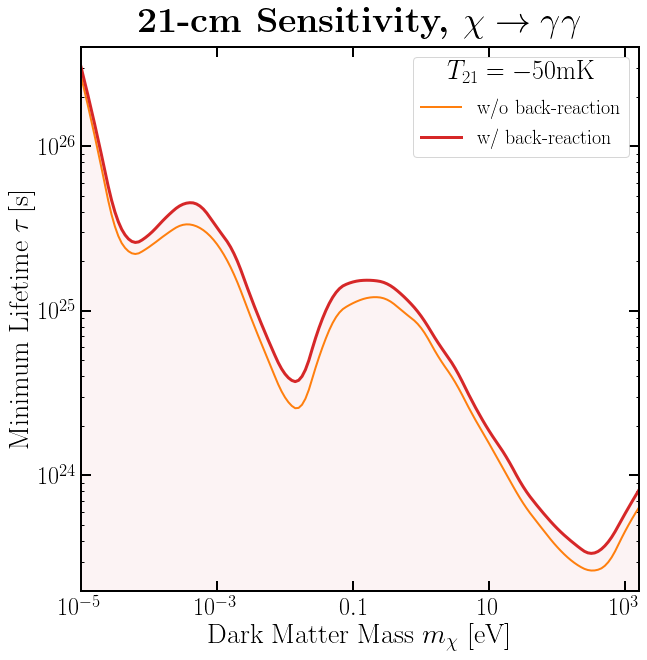

In [712]:
log10mDM_arr_fine = np.log10(10**np.arange(log10mDM_arr[0], log10mDM_arr[-1], 0.05))

plt.figure()
ax = plt.gca()
ax.loglog()

ymin = 2e23
ymax = 4e26

xmin = 10**log10mDM_arr_fine[0]/1e9
xmax = 10**log10mDM_arr_fine[-1]/1e9

if inj_particle == 'electron':
    plt.title(r'\bf{21-cm Sensitivity,} $\chi \to e^+ e^-$')
else:
    plt.title(r'\bf{21-cm Sensitivity,} $\chi \to \gamma\gamma$')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
plt.ylabel(r'Minimum Lifetime $\tau \, [\mathrm{s}]$')
plt.axis([xmin, xmax, ymin, ymax])

plt_std, = plt.plot(10**log10mDM_arr_fine/1e9, 10**std_interp(log10mDM_arr_fine), 
        linewidth=2, label='w/o back-reaction', color='C1')
plt_BR, = plt.plot(10**log10mDM_arr_fine/1e9, 10**BR_interp(log10mDM_arr_fine), 
         linewidth=3, label='w/ back-reaction', color='C3')

ax.fill_between(
    10**log10mDM_arr_fine/1e9, 
    1e-15, 
    (10**BR_interp(log10mDM_arr_fine)), 
    interpolate=True, 
    color='C3',
    alpha=.05
)

leg = plt.legend(handles=[plt_std, plt_BR],
                 fontsize=20,
          title='$T_{21} = -50$mK')
plt.setp(leg.get_title(), fontsize=26)

plt.savefig('/Users/gridgway/Dropbox (MIT)/Photon Deposition/Draft/plots/'+
            'DarkHistory_21cm_Sensitivity_'+inj_type+'_'+inj_str+'.png')

# photon decay

In [ ]:
inj_particle = 'photon'
inj_str = inj_particle[:4]
inj_type = 'decay'

if inj_type == 'swave':
    struct_boost = struct_boost_einasto
    struct_func = struct_boost
else:
    def struct_boost(rs):
        return 1
    struct_func = None
    
if inj_particle == 'photon':
    mass = 0
    coarsen_factor=4
else:
    mass = phys.me
    coarsen_factor=12
    
end_rs = 18.2
rs_init = 3000

In [ ]:
def get_T(mDM, std_soln):
    if inj_type == 'decay':
        Einj = mDM/2-mass
        Ecom=mDM
    if inj_type == 'swave':
        Einj = mDM - mass
        Ecom = 2*mDM

    if inj_particle == 'photon':
        Etmp = photeng[photeng < Einj][-1]
        phot_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            photeng
        )
        phot_spec_init.rs = rs_init
        phot_spec_init.switch_spec_type()

        elec_spec_init = Spectrum(eleceng,
                                 np.zeros_like(eleceng),
                                 spec_type='N',
                                 rs=rs_init)
    else:
        Etmp = eleceng[eleceng < Einj][-1]
        elec_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            eleceng
        )
        elec_spec_init.rs = rs_init
        elec_spec_init.switch_spec_type()

        phot_spec_init = Spectrum(photeng,
                                 np.zeros_like(photeng),
                                 spec_type='N',
                                 rs=rs_init)

    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, tau=10**log10_p, sigmav=10**log10_p*mDM/1e9)*struct_boost(rs)/Ecom
    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, tau=10**log10_p, sigmav=10**log10_p*mDM/1e9)*struct_boost(rs)

    a = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_N, rate_func_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=coarsen_factor, std_soln=std_soln,
        reion_switch=False,
        struct_boost=struct_func,
        ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
        user=None, verbose=False, 
        use_tqdm=True
    )
    return a[1][-1]/phys.kB

In [ ]:
%autoreload
step = .25
if inj_particle == 'photon':
    mbnds = [4,12.5]
    log10mDM_arr = np.arange(mbnds[0], mbnds[1], step)

    if inj_type == 'decay':
        parambnds = [23,28.25 + step] #tau
        param_guess = 27
    else:
        parambnds = [-28,-25 + step] # sigma v / mDM
        param_guess = -27
else:
    mbnds = [6.01,12.51]
    log10mDM_arr = np.arange(mbnds[0], mbnds[1], step)

    if inj_type == 'decay':
        parambnds = [24,28.25 + step]
        param_guess = 27
    else:    
        parambnds = [-30.5,-24.5 + step]
        param_guess = -27
    
log10_param = np.arange(parambnds[0], parambnds[1], step)

In [ ]:
T_21 = -50 #in mK
tmp_xe = xe_std(end_rs)
num = np.sqrt(.15/10/phys.omega_m*end_rs)*(phys.omega_baryon*phys.h/.02)*(1-tmp_xe)*23
one_minus_ratio = T_21 / num
Tm_bnd = phys.TCMB(end_rs)/(1-one_minus_ratio)/phys.kB
print("T_m < ", Tm_bnd, "K")

In [ ]:
%autoreload
T_IGM_17_std = np.zeros((log10mDM_arr.size, log10_param.size))
BR_guesses = np.zeros(log10mDM_arr.size)

for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
    print('log10(mDM): ', log10mDM)
    mDM = 10**log10mDM
    j=len(log10_param[log10_param < param_guess])
    above=False
    below=False

    while((not below) or (not above)):
        log10_p = log10_param[j]
        print('log10(param): ', log10_p)

        T_std = get_T(mDM, True)
        T_IGM_17_std[i,j] = T_std
        print('T_0 [K]: ', T_std)

        if T_std > Tm_bnd:
            above = True
            print("T_std Above Threshold")
            j = j-1
        else:
            below = True
            print("T_std Below Threshold")
            j = j+1
            
        param_guess = log10_p
        BR_guesses[i] = log10_param[j-1]
        
                    
pickle.dump(
    T_IGM_17_std, 
#     open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_std_NFW_no_subs_source.dat','wb')
    open('/Users/gridgway/Desktop/T_IGM_17_'+
         inj_str+'_'+inj_type+'_std_coarsen'+str(coarsen_factor)+'.dat','wb')
)

In [ ]:
%autoreload
T_IGM_17_BR = np.zeros((log10mDM_arr.size, log10_param.size))

for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
    print('log10(mDM): ', log10mDM)
    mDM = 10**log10mDM
    j=len(log10_param[log10_param < BR_guesses[i]])
    above=False
    below=False

    while((not below) or (not above)):
        log10_p = log10_param[j]
        print('log10(param): ', log10_p)

        T_BR = get_T(mDM, True)
        T_IGM_17_BR[i,j] = T_BR
        print('T_0 [K]: ', T_BR)

        if T_BR > Tm_bnd:
            above = True
            print("T_BR Above Threshold")
            j = j-1
        else:
            below = True
            print("T_BR Below Threshold")
            j = j+1
        
                    
pickle.dump(
    T_IGM_17_BR, 
#     open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_BR_NFW_no_subs_source.dat','wb')
    open('/Users/gridgway/Desktop/T_IGM_17_'+
         inj_str+'_'+inj_type+'_BR_coarsen'+str(coarsen_factor)+'.dat','wb')
)

# Scratch

In [ ]:
log10mDM_arr_old = np.arange(4, 12.5, 0.5)
log10_tau_decay_old = np.arange(21, 30, 0.25)
T_IGM_17_old = pickle.load(open('/Users/gridgway/Dropbox (MIT)/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_source.dat','rb'))

T_IGM_arr_old = np.arange(7.1, 50.+0.1, 0.1)
log10tau_arr_old = np.zeros((log10mDM_arr_old.size, T_IGM_arr_old.size))

for i,log10mDM in enumerate(log10mDM_arr_old):
    tau_interp = interp1d(
        T_IGM_17_phot_decay_old[i,:], log10_tau_decay_old, 
        bounds_error = False,
        fill_value = (100, 0)
                         )
    log10tau_phot_decay_arr_old[i,:] = tau_interp(T_IGM_arr_old)

log10tau_phot_decay_old = interp2d(log10mDM_arr_old, T_IGM_arr_old, np.transpose(log10tau_phot_decay_arr_old), kind='cubic')

[1000000.0, 100000000000.0, 1e-29, 1e-24]

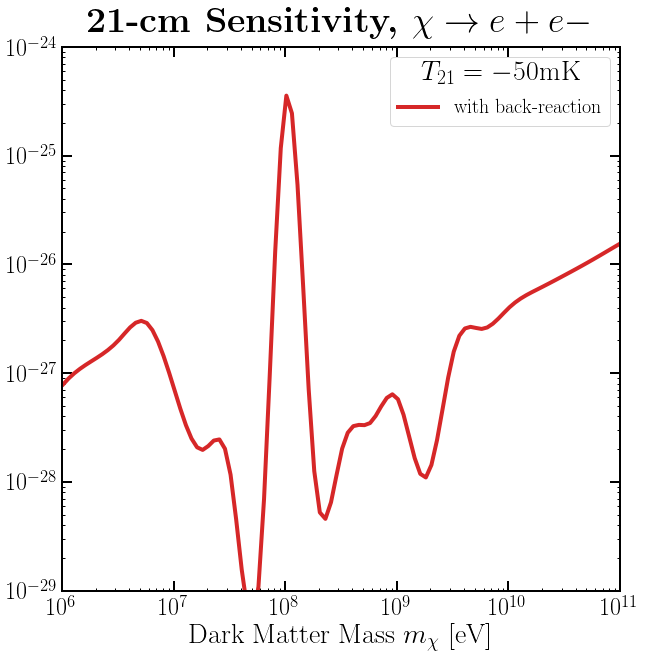

In [451]:
T_IGM_arr = np.arange(7.1, 50.+0.1, 0.1)
log10param = np.zeros((log10mDM_arr.size, T_IGM_arr.size))

for i,log10mDM in enumerate(log10mDM_arr):
    param_interp = interp1d(
        T_IGM_17_std[i,:], log10_param, 
        bounds_error = False,
        fill_value = (-50, 100)
    )
    log10param[i,:] = param_interp(T_IGM_arr)
    
log10param = interp2d(log10mDM_arr, T_IGM_arr, 
                                  np.transpose(log10param), kind='cubic')

log10mDM_arr_fine = np.log10(10**np.arange(log10mDM_arr[0], log10mDM_arr[-1], 0.05))

plt.figure()

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


# ax.fill_between(
#     10**log10mDM_arr_fine, 
#     1e23, 
#     (10**log10tau_phot_decay_old(log10mDM_arr_fine,T_m)), 
#     interpolate=True, 
#     color='C1',
#     alpha=.05
# )

plt_backReact, = plt.plot(10**log10mDM_arr_fine, 
                  (10**log10param(log10mDM_arr_fine,T_m))
                  , linewidth=4, label='with back-reaction', color='C3')



leg = plt.legend(handles=[plt_backReact],
                 fontsize=20,
          title='$T_{21} = -50$mK')
plt.setp(leg.get_title(), fontsize=28)


ymin = 1e-29
ymax = 1e-24

xmin = 1e6
xmax = 1e11

plt.title(r'\bf{21-cm Sensitivity,} $\chi \to e+ e-$')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
# plt.ylabel(r'Minimum Lifetime $\tau [\mathrm{ s}]$')
# plt.axis([xmin, xmax, ymin, ymax])
plt.axis([xmin, xmax, ymin, ymax])

# plt.savefig('/Users/gridgway/Desktop/DarkHistory_21cm_Sensitivity_Decay.png')

In [45]:
end_rs = 1000

#inputs for the tau, mDM sweep
mDM = 1e4

tau = 1e21

phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                np.array([mDM/2]), 
                                highengphot_tf_interp.eng)
phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()
        
def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)
        
a = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=True
)

print((a[1][-1]-phys.TCMB(end_rs))/phys.TCMB(end_rs))

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),
/Users/GregoryRidgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.00188641095602


In [49]:
%autoreload

end_rs = 18.2

#inputs for the tau, mDM sweep
mbnds = [4,4.5]
log10mDM_arr = np.arange(mbnds[0], mbnds[1], 0.5)

taubnds = [21,21.5]
log10_tau_decay = np.arange(taubnds[0], taubnds[1], 0.5)

T_IGM_17_phot_decay_backReact = np.zeros((log10mDM_arr.size, log10_tau_decay.size))

print("Starting Loop")
#Calculating T_IGM(z=17.2) for a grid of (tau,mDM) points.
for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
    for j, log10_tau in enumerate(tqdm(log10_tau_decay)):
        phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([10**log10mDM/2]), 
                                      highengphot_tf_interp.eng)
        phot_spec_init.rs = 3000
        phot_spec_init.switch_spec_type()
        
        def rate_func_decay_N(rs):
            # This is dN/dV dt
            return phys.inj_rate('decay', rs, tau=10**log10_tau)/10**log10mDM

        def rate_func_decay_eng(rs):
            # This is dN/dV dt
            return phys.inj_rate('decay', rs, tau=10**log10_tau)
        
        a = main.evolve(
            phot_spec_init*0, phot_spec_init,
            rate_func_decay_N, rate_func_decay_eng, end_rs,
            highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
            xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
            coarsen_factor=1, std_soln=True
        )
            
        b = main.evolve(
            phot_spec_init*0, phot_spec_init,
            rate_func_decay_N, rate_func_decay_eng, end_rs,
            highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
            xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
            coarsen_factor=1, std_soln=False
        )

        T_IGM_17_phot_decay_backReact[i,j] = b[1][-1]/phys.kB
        
# pickle.dump(
#     T_IGM_17_phot_decay_backReact, 
#     open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_backReact_NFW_no_subs_source.dat','wb')
# )

rs_vec = b[3].rs

Starting Loop


A Jupyter Widget

A Jupyter Widget

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),
/Users/GregoryRidgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [50]:
print("DarkHistory Backreaction: ", T_IGM_17_phot_decay_backReact[0,0])
print("DarkHistory no Backreaction: ", a[1][-1]/phys.kB)
T_IGM_17_phot_decay_std = pickle.load(open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_source.dat','rb'))
print("Old results old 21cm notebook, Additional Sources.ipynb: ", T_IGM_17_phot_decay_std[0,0])

DarkHistory Backreaction:  128622.736236
DarkHistory no Backreaction:  5633.18316181
Old results old 21cm notebook, Additional Sources.ipynb:  241682.368757


In [128]:
%autoreload

end_rs = 18.2

mbnds = [4,11.5]
log10mDM_arr = np.arange(mbnds[0], mbnds[1], 0.5)

taubnds = [21,30]
log10_tau_decay = np.arange(taubnds[0], taubnds[1], 0.5)

T_IGM_17_phot_decay_backReact = np.zeros((log10mDM_arr.size, log10_tau_decay.size))


#Calculating T_IGM(z=17.2) for a grid of (tau,mDM) points.
for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
    for j, log10_tau in enumerate(tqdm(log10_tau_decay)):
        mDM = 10**log10mDM
        Einj = mDM/2
        Ecom=mDM
        
        phot_spec_init.rs = 3000
        
        Etmp = photeng[photeng < Einj][-1]
        phot_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            photeng
        )
        phot_spec_init.rs = 3000
        phot_spec_init.switch_spec_type()
        
        elec_spec_init = Spectrum(eleceng,
                                 np.zeros_like(eleceng),
                                 spec_type='N',
                                 rs=3000)
        
        def rate_func_N(rs):
            return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
        def rate_func_eng(rs):
            return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)
        
        a = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_N, rate_func_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=1, std_soln=True,
        reion_switch=False,
        struct_boost=None,
        ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
        xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
        use_tqdm=True
        )

        b = main.evolve(
            elec_spec_init, phot_spec_init,
            rate_func_N, rate_func_eng, end_rs,
            highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
            highengdep_interp, CMB_engloss_interp,
            ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
            coarsen_factor=1, std_soln=False,
            reion_switch=False,
            struct_boost=None,
            ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
            xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
            use_tqdm=True
        )

        T_IGM_17_phot_decay_std[i,j] = a[1][-1]/phys.kB
        T_IGM_17_phot_decay_backReact[i,j] = b[1][-1]/phys.kB
        
pickle.dump(
    T_IGM_17_phot_decay_std, 
#     open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_std_NFW_no_subs_source.dat','wb')
    open('/Users/GregoryRidgway/Desktop/T_IGM_17_phot_decay_std_NFW_no_subs_source.dat','wb')
)
        
pickle.dump(
    T_IGM_17_phot_decay_backReact, 
#     open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_backReact_NFW_no_subs_source.dat','wb')
    open('/Users/GregoryRidgway/Desktop/T_IGM_17_phot_decay_backReact_NFW_no_subs_source.dat','wb')
)

rs_vec = b[3].rs


start to evolve
rs, fs:  2994.005996001995   [5.010253871064946e-06, 3.139708532323484e-05, 0.0002113287238244386, 2.6324947675953802e-18, 0.002632474604939014]
rs, fs:  2988.023968031968   [2.0911031212181267e-05, 0.00011400683398819265, 0.0006591080663632204, 8.31465202515223e-18, 0.008314585865768418]
rs, fs:  2982.053892161797   [4.3113566113991716e-05, 0.00021772541128304762, 0.0011326374444918987, 1.4426114020448714e-17, 0.014425994774152791]


../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:662: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


rs, fs:  2976.095744511174   [6.995630529748119e-05, 0.00033668626888452456, 0.0016229273624116104, 2.0844959714827655e-17, 0.02084478078346178]
rs, fs:  2970.149501247497   [0.00010017927491325333, 0.0004664165507982195, 0.002123144617948969, 2.7496366674205697e-17, 0.027496121629245987]
rs, fs:  2964.215138585785   [0.0001328065141706632, 0.0006034624394151668, 0.002628045542201953, 3.4330210546906635e-17, 0.03432989295674459]
rs, fs:  2958.29263278858   [0.00016707148202139377, 0.0007451358774270877, 0.0031335852289433603, 4.130976494437962e-17, 0.041309368279188616]
rs, fs:  2952.38196016585   [0.00020236693922506726, 0.0008893355428200465, 0.003636637536537389, 4.8405958937941095e-17, 0.04840547651436769]
start to evolve
rs, fs:  2994.005996001995   [5.010253871064946e-06, 3.139708532323484e-05, 0.0002113287238244386, 2.6324746119861177e-18, 0.002632474604939014]
rs, fs:  2988.023968031968   [2.0911031212181267e-05, 0.00011400683398819265, 0.0006591080663632204, 8.314649672411521e

In [ ]:
#injection energy, DM mass, center-of-mass energy
    
        
        
    
    
    data[i] = (a,b)

    diff_list[i] = (1-b[1]/a[1]) * 100

What was computed before using `21cm_pwave/TLA_code/examples/old_notebooks/Additional_Sources.ipynb`

In [18]:
log10mDM_arr = np.arange(4, 12.5, 0.5)
log10_tau_decay = np.arange(21, 30, 0.25)
T_IGM_17_phot_decay = pickle.load(open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_source.dat','rb'))

T_IGM_arr = np.arange(7.1, 50.+0.1, 0.1)
log10tau_phot_decay_arr = np.zeros((log10mDM_arr.size, T_IGM_arr.size))

for i,log10mDM in enumerate(log10mDM_arr):
    tau_interp = interp1d(
        T_IGM_17_phot_decay[i,:], log10_tau_decay, 
        bounds_error = False,
        fill_value = (100, 0)
                         )
    log10tau_phot_decay_arr[i,:] = tau_interp(T_IGM_arr)

log10tau_phot_decay_old = interp2d(log10mDM_arr, T_IGM_arr, np.transpose(log10tau_phot_decay_arr), kind='cubic')

DarkHistory (with Backreaction)

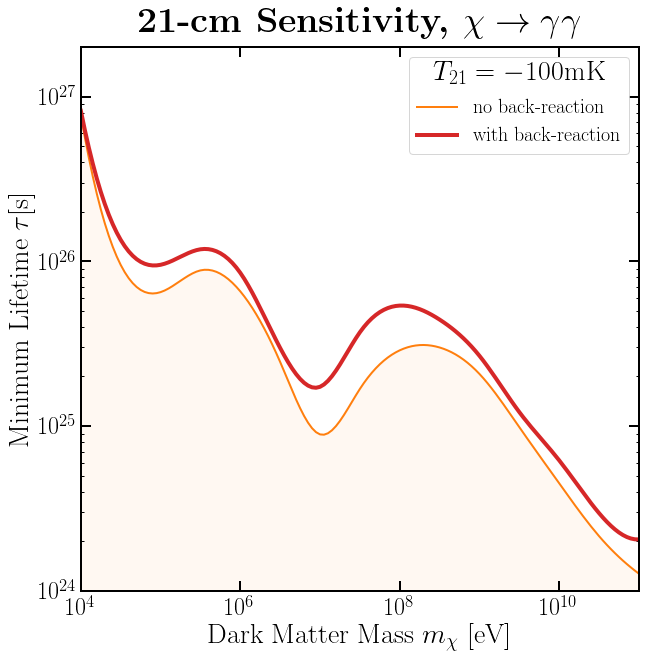

In [67]:
T_21 = -.1

#Specify grid of mDM and tau
mbnds = [4,11.5]
log10mDM_arr = np.arange(mbnds[0], mbnds[1], 0.5)
taubnds = [23,28]
log10_tau_decay = np.arange(taubnds[0], taubnds[1], 0.5)

## Load T(z=17.2) data, with and without backreaction
# T_IGM_17_phot_decay_std = pickle.load(
#     open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/'+
#          'T_IGM_17_phot_decay_std_NFW_no_subs_source.dat','rb')
# )

T_IGM_17_phot_decay_backReact = pickle.load(
    open('/Users/GregoryRidgway/Downloads/T_IGM_17_phot_decay_backReact.dat','rb')
)

T_IGM_arr = np.arange(7.1, 50.+0.1, 0.1)
log10tau_phot_decay_arr_backReact = np.zeros((log10mDM_arr.size, T_IGM_arr.size))
# log10tau_phot_decay_arr_std = np.zeros((log10mDM_arr.size, T_IGM_arr.size))

for i,log10mDM in enumerate(log10mDM_arr):
    tau_interp_backReact = interp1d(
        T_IGM_17_phot_decay_backReact[i,:], log10_tau_decay, 
        bounds_error = False,
        fill_value = (-50, 100)
    )
    log10tau_phot_decay_arr_backReact[i,:] = tau_interp_backReact(T_IGM_arr)
    
#     tau_interp_std = interp1d(
#         T_IGM_17_phot_decay_std[i,:], log10_tau_decay, 
#         bounds_error = False,
#         fill_value = (-50, 100)
#     )
#     log10tau_phot_decay_arr_std[i,:] = tau_interp_std(T_IGM_arr)
    
log10tau_phot_decay_backReact = interp2d(log10mDM_arr, T_IGM_arr, 
                                  np.transpose(log10tau_phot_decay_arr_backReact), kind='cubic')
# log10tau_phot_decay_std = interp2d(log10mDM_arr, T_IGM_arr, 
#                                   np.transpose(log10tau_phot_decay_arr_std), kind='cubic')


log10mDM_arr_fine = np.log10(10**np.arange(mbnds[0], mbnds[1], 0.05))

plt.figure()

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

tmp_xe=0
num = np.sqrt(.15/10/phys.omega_m)*(phys.omega_baryon*phys.h/.02)*23*.001
one_minus_ratio = T_21 / num / (1-tmp_xe) / np.sqrt(1+17.2)
temp_dat = 1-one_minus_ratio
T_m = phys.TCMB(17.2)/temp_dat/phys.kB
# T_m = 10.5

plt_old, = plt.plot(10**log10mDM_arr_fine, 
                  (10**log10tau_phot_decay_old(log10mDM_arr_fine,T_m))
                  , linewidth=2, label='no back-reaction', color='C1')
# plt.text()

ax.fill_between(
    10**log10mDM_arr_fine, 
    1e23, 
    (10**log10tau_phot_decay_old(log10mDM_arr_fine,T_m)), 
    interpolate=True, 
    color='C1',
    alpha=.05
)



# plt_std, = plt.plot(10**log10mDM_arr_fine, 
#                   (10**log10tau_phot_decay_std(log10mDM_arr_fine,T_m))
#                   , linewidth=2, label='No Backreaction')

plt_backReact, = plt.plot(10**log10mDM_arr_fine, 
                  (10**log10tau_phot_decay_backReact(log10mDM_arr_fine,T_m))
                  , linewidth=4, label='with back-reaction', color='C3')



# plt_D, = plt.plot(ms_D, sigs_D, 'k', linewidth=2, label='Diamanti et. al., 1308.2578')

leg = plt.legend(handles=[plt_old, plt_backReact],
                 fontsize=20,
          title='$T_{21} = -100$mK')
plt.setp(leg.get_title(), fontsize=28)


ymin = 1e24
ymax = 2e27

xmin = 1e4
xmax = 1e11

plt.title(r'\bf{21-cm Sensitivity,} $\chi \to \gamma \gamma$')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
plt.ylabel(r'Minimum Lifetime $\tau [\mathrm{ s}]$')
# plt.axis([xmin, xmax, ymin, ymax])
plt.axis([xmin, xmax, ymin, ymax])

plt.savefig('/Users/GregoryRidgway/Desktop/DarkHistory_21cm_Sensitivity_Decay.pdf')